In [1]:
#!pip install kagglehub

In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("willianoliveiragibin/web-network")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\luigi\.cache\kagglehub\datasets\willianoliveiragibin\web-network\versions\2


In [10]:
df=pd.read_csv(path+"/test traficct new.csv")


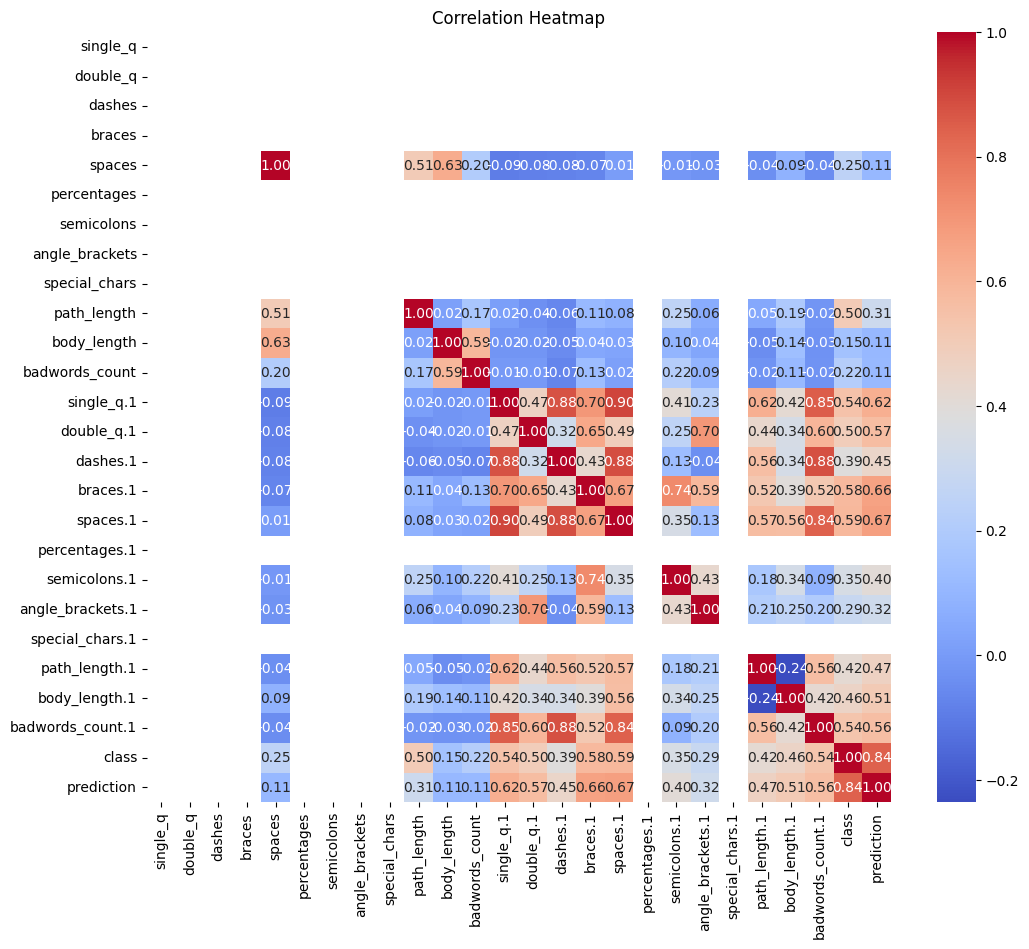

In [11]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X = numeric_df.drop(columns=['class', 'prediction'])
y = numeric_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [13]:
import numpy as np
from scipy.stats import norm

class GaussianNaiveBayes:
    """
    Implementazione del Naive Bayes Gaussiano per caratteristiche continue.
    
    Il Naive Bayes Gaussiano assume che le feature continue seguano una 
    distribuzione normale (gaussiana) all'interno di ogni classe.
    
    Parametri:
    ----------
    var_smoothing : float, default=1e-9
        Valore aggiunto alle varianze per evitare divisioni per zero.
    """
    
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.class_priors = {}  # Probabilità a priori delle classi
        self.means = {}         # Media per ogni feature per ogni classe
        self.variances = {}     # Varianza per ogni feature per ogni classe
        self.classes = None     # Classi possibili
        self.n_features = None  # Numero di feature
        
    def fit(self, X, y):
        """
        Addestra il classificatore Naive Bayes Gaussiano.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Matrice delle feature continue.
        y : array-like, shape (n_samples,)
            Vettore delle classi.
        
        Returns:
        --------
        self : object
        """
        X = np.asarray(X)
        y = np.asarray(y)
        
        n_samples, self.n_features = X.shape
        self.classes = np.unique(y)
        
        # Calcolo delle probabilità a priori delle classi
        for c in self.classes:
            self.class_priors[c] = np.mean(y == c)
            self.means[c] = {}
            self.variances[c] = {}
            
            # Calcolo media e varianza per ogni feature per questa classe
            X_c = X[y == c]
            
            for feature_idx in range(self.n_features):
                feature_values = X_c[:, feature_idx]
                
                # Calcolo media
                self.means[c][feature_idx] = np.mean(feature_values)
                
                # Calcolo varianza (con smoothing)
                self.variances[c][feature_idx] = np.var(feature_values) + self.var_smoothing
        
        return self
    
    def _calculate_gaussian_probability(self, x, mean, variance):
        """
        Calcola la densità di probabilità gaussiana.
        
        Parametri:
        ----------
        x : float
            Valore di cui calcolare la probabilità.
        mean : float
            Media della distribuzione gaussiana.
        variance : float
            Varianza della distribuzione gaussiana.
        
        Returns:
        --------
        float : Densità di probabilità calcolata.
        """
        # Implementazione diretta della formula della densità gaussiana
        exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
        return exponent / np.sqrt(2 * np.pi * variance)
        
    def predict_log_proba(self, X):
        """
        Calcola il logaritmo delle probabilità per ciascuna classe.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Matrice delle feature continue.
        
        Returns:
        --------
        array, shape (n_samples, n_classes) : Log-probabilità per ogni classe.
        """
        X = np.asarray(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_probs = np.zeros((n_samples, n_classes))
        
        for i in range(n_samples):
            for j, c in enumerate(self.classes):
                # Probabilità a priori (in log-spazio)
                log_prob = np.log(self.class_priors[c])
                
                # Somma dei logaritmi delle probabilità condizionate
                for feature_idx in range(self.n_features):
                    x_value = X[i, feature_idx]
                    mean = self.means[c][feature_idx]
                    variance = self.variances[c][feature_idx]
                    
                    # Calcoliamo la densità gaussiana e ne prendiamo il logaritmo
                    gaussian_prob = self._calculate_gaussian_probability(x_value, mean, variance)
                    
                    # Proteggiamoci da log(0)
                    if gaussian_prob > 0:
                        log_prob += np.log(gaussian_prob)
                    else:
                        log_prob += np.log(1e-10)  # Un valore molto piccolo
                
                log_probs[i, j] = log_prob
        
        return log_probs
    
    def predict_proba(self, X):
        """
        Restituisce le probabilità normalizzate delle classi.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Matrice delle feature continue.
        
        Returns:
        --------
        array, shape (n_samples, n_classes) : Probabilità per ogni classe.
        """
        log_probs = self.predict_log_proba(X)
        
        # Normalizzazione numericamente stabile (log-sum-exp trick)
        log_prob_max = np.max(log_probs, axis=1).reshape(-1, 1)
        probs = np.exp(log_probs - log_prob_max)
        probs_sum = np.sum(probs, axis=1).reshape(-1, 1)
        
        return probs / probs_sum
    
    def predict(self, X):
        """
        Predice le classi per i campioni in X.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Matrice delle feature continue.
        
        Returns:
        --------
        array, shape (n_samples,) : Le classi predette.
        """
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]
    
    def score(self, X, y):
        """
        Calcola l'accuratezza del classificatore.
        
        Parametri:
        ----------
        X : array-like, shape (n_samples, n_features)
            Matrice delle feature continue di test.
        y : array-like, shape (n_samples,)
            Classi vere dei campioni di test.
        
        Returns:
        --------
        float : Accuratezza del classificatore.
        """
        return np.mean(self.predict(X) == y)

Accuracy score: 0.9426751592356688

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        80
           1       0.99      0.90      0.94        77

    accuracy                           0.94       157
   macro avg       0.95      0.94      0.94       157
weighted avg       0.95      0.94      0.94       157



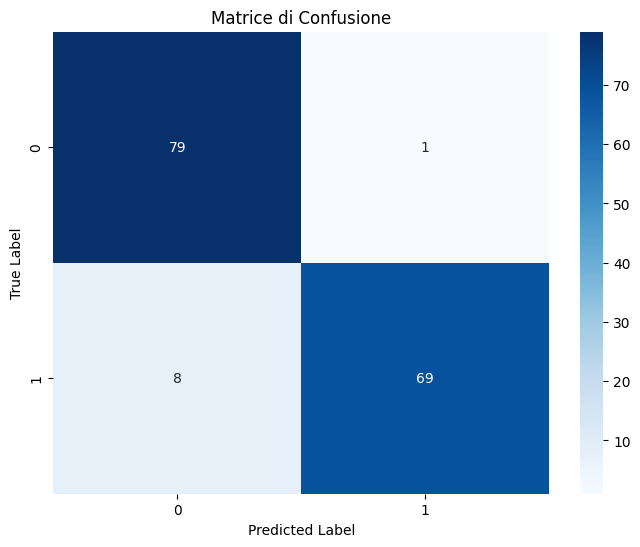

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Normalizziamo i dati
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

# Creiamo e addestriamo il modello
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train_scaled, y_train)

# Facciamo predizioni
y_pred = nb_classifier.predict(X_test_scaled)

# Valutiamo le performance
print("Accuracy score:", nb_classifier.score(X_test_scaled, y_test))

# Report dettagliato
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()